# Notes

This assignment is partially autograded. Problems 2 and 3 are graded manually according to the following rules:

- **1 point**: attempt was made, but solution is not correct,
- **2 points**: solution is generally correct, but is not efficient/has unreasonably low performance,
- **3 points**: solution is correct, is efficient/has reasonably high performance.

Problem 1 is auto-graded.

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import torch
from sklearn import datasets

In [4]:
STUDENT = "Adam Cohn"
ASSIGNMENT = 3
TEST = False

In [5]:
if TEST:
    import solutions
    total_grade = 0
    MAX_POINTS = 6

# Gradients

### 1. Generate gradient (1 point).

For 2-dimensional tensor `tr`, calculate a gradient of $\sum\log tr_{ij}$. Note, that you're provided with dimensions and interval:

- `dims` is a tuple, so that `tr.size()` equals `dims`,
- `lims` is an interval, so that `tr` elements are integeres, uniformly sampled from `[lims[0], lims[1])` interval (note, that lims[1] is **not** included).

Result must be a tensor of the same shape as `tr`, containing gradients of the following function:

$$\sum_{ij}\log tr_{ij}.$$

Result **will be tested against multiple random combinations of input tensor dimensions ($10 \leq n < 100 $) and sampling interval (`lims[0]=1`, `10 <= lims[1] < 100`)**.

In [6]:
def generate_grad(dims, lims):
    """Generate gradient of `log(x)`."""
    tr = torch.randint(lims[0], lims[1], dims, dtype=float, requires_grad=True)
    a = tr.log().sum()
    a.backward()
    return tr.grad

In [7]:
PROBLEM_ID = 1

if TEST:
    total_grade += solutions.check(STUDENT, PROBLEM_ID, generate_grad)

### 2. Find a minimum (2 points, manually graded).

Consider the following scalar function:

$$
f(x) = ax^2 + bx + c
$$

Given the $a,b,c$, find $x$, which minimizes $f'(x)$. Note this:

- $a,b,c$ are fixed, and generated in such a way, that minimum always exists ($f(x)$ is convex),
- $x$ is a scalar value, i.e. 0-dimensional tensor.

In [8]:
def generate_coeffs():
    a = torch.rand(size=()) * 10
    b = -10 + torch.rand(size=()) * 10
    c = -10 + torch.rand(size=()) * 10
    return a, b, c

def func(x, a, b, c):
    return x.pow(2) * a + x * b + c

In [9]:
EPOCHS = 20
LR = 1e-1
DELTA = 0.000001
STARTING_VAL = 51. # Consider choosing different starting values for x to speed-up the optimization

# Initialize x, a, b, c
x = torch.tensor(STARTING_VAL, requires_grad=True)
a, b, c = generate_coeffs()

# Collect f(x) values during training for visuzalition later on
f_vals = []

for i in range(EPOCHS):
    # Your code goes here
    z = func(x, a, b, c)
    z.backward()
    f_vals.append(z.item())
    with torch.no_grad():
        x.sub_(LR * x.grad)
    x.grad.zero_()

    print(f"Epoch {i}: F(x)= {f_vals[-1]}")
    
    try:
        if f_vals[-2] - f_vals[-1] < DELTA:
            break
    except:
        pass


Epoch 0: F(x)= 16074.9580078125
Epoch 1: F(x)= 1139.0408935546875
Epoch 2: F(x)= 76.80294799804688
Epoch 3: F(x)= 1.2569293975830078
Epoch 4: F(x)= -4.115880489349365
Epoch 5: F(x)= -4.497992992401123
Epoch 6: F(x)= -4.5251688957214355
Epoch 7: F(x)= -4.527101516723633
Epoch 8: F(x)= -4.527238845825195
Epoch 9: F(x)= -4.527248382568359
Epoch 10: F(x)= -4.527249336242676


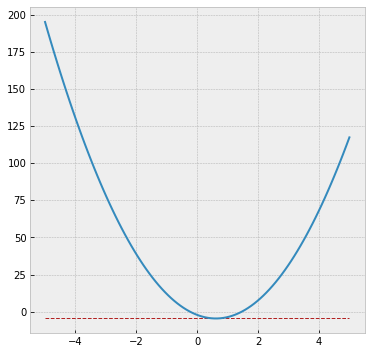

In [10]:
if f_vals:
    grid = np.linspace(-5, 5, 100)
    plt.plot(grid, np.square(grid) * a.item() + grid * b.item() + c.item())
    plt.hlines(f_vals[-1], -5, 5, "firebrick", "--", linewidth=1)

In [11]:
PROBLEM_ID = 2
GRADE = 0

if TEST:
    total_grade += GRADE

### 3. Simple neural network model (3 points, manually graded).

Construct non-linear model for binary classification. Use logistic regressions example from class as a blueprint. Experiment with different number of intermediate layers and their sizes to achieve good performance.

For a reference, imagine a neural network with a single hidden layer with $N$ neurons. Then, input $X$ is first transformed as:

$$
X^{hidden}_{ik} = \sigma(X_{ij}W^{hidden}_{jk} + b^{hidden}_k),
$$
$$
\hat y_{i} = \sigma(X^{hidden}_{ij}W_{j} + b).
$$

After this, $X^{hidden}_{ik}$ can be considered as an input to the same logistic regression model we had in class. The bonus is that we performed non-linear transformation of pur original coordinates and can now catch non-linear decision boundary (as is the case for our mock data).

Note also, that $X$ has shape $(N, 2)$ (where $N$ is number of training examples), $W^{hidden}_{jk}$ has shape of $(2, N^{hidden})$ and $b^{hidden}_k$ has shape $(N^{hidden})$. At the same time, $W$ has shape $(N^{hidden},)$ and $b$ is a scalar (the same way it was for logistic regression). This model can be considered as a logistic regression on transformed coordinates, but we learn the transformation itself.

There may be multiple hidden layers, but start from a single one.

In [165]:
N_LAYERS = 4
N_HIDDEN = (2,20,10,4) + (1,)

In [166]:
X, y = datasets.make_moons(1000, noise=.25)

In [167]:
X

array([[-1.04951495, -0.20657087],
       [ 2.02265541,  0.30904858],
       [ 0.34894734,  0.41089636],
       ...,
       [ 1.01680024,  0.43969921],
       [ 1.01340976,  0.00586449],
       [-0.63378561,  0.21702416]])

In [168]:
Xt = torch.tensor(X, dtype=torch.float)
yt = torch.tensor(np.expand_dims(y, axis=-1), dtype=torch.float)

In [169]:
weights = []
biases = []

for i in range(N_LAYERS):
    # Initialize w and b for layer i with number of "neurons" of N_HIDDEN[i]
    w = torch.randn(N_HIDDEN[i], N_HIDDEN[i+1], requires_grad=True) # <- your code goes here
    b = torch.randn(N_HIDDEN[i+1], requires_grad=True) # <- your code goes here
    weights.append(w)
    biases.append(b)

In [170]:
def sigmoid(a):
    """Sigmoid activation function."""

    return 1/(1 + (-a).exp())

def relu(a):
    a[a<0] = 0
    return a

def output(X, weights, biases):
    """Calculate neural network output."""
    for i, w in enumerate(weights[:-1]):
        X = relu(torch.mm(X, weights[i]) + biases[i])
    return sigmoid(torch.mm(X, weights[-1]) + biases[-1]) # <- your code goes here

def logloss(y, y_pred):
    return -(y * torch.log(y_pred) + (1 - y) * torch.log(1 - y_pred)).mean()

In [171]:
EPOCHS = 1000
LR = 1e-2
DELTA = 0.00001
loss_history = []

for i in range(EPOCHS):
    y_pred = output(Xt, weights, biases)
    loss = logloss(yt, y_pred)
    loss.backward()
    
    loss_history.append(loss.item())

    with torch.no_grad():
        # update all the weights and biases
        # your code goes here
        for j, _ in enumerate(weights):
            weights[j].sub_(weights[j].grad*LR)
            biases[j].sub_(biases[j].grad*LR)
            

    # wipe out all gradients
    # your code goes here
    for j, p in enumerate(weights):
        weights[j].grad.zero_()
        biases[j].grad.zero_()
        
    if i % 20 == 0:
        print(f"Epoch {i}: loss = {loss_history[-1]}")
    
    try:
        if loss_history[-2] - loss_history[-1] < DELTA:
            break
    except:
        pass

Epoch 0: loss = 6.592698574066162
Epoch 20: loss = 0.4275621473789215
Epoch 40: loss = 0.3796597123146057
Epoch 60: loss = 0.353727787733078
Epoch 80: loss = 0.3333439230918884
Epoch 100: loss = 0.3087006211280823
Epoch 120: loss = 0.275169312953949
Epoch 140: loss = 0.24635669589042664
Epoch 160: loss = 0.22139449417591095
Epoch 180: loss = 0.20598818361759186
Epoch 200: loss = 0.19496013224124908
Epoch 220: loss = 0.18546880781650543
Epoch 240: loss = 0.17586924135684967
Epoch 260: loss = 0.16920533776283264
Epoch 280: loss = 0.16450384259223938
Epoch 300: loss = 0.16090774536132812
Epoch 320: loss = 0.157858744263649
Epoch 340: loss = 0.1552533209323883
Epoch 360: loss = 0.15296487510204315
Epoch 380: loss = 0.15095451474189758
Epoch 400: loss = 0.1491597443819046
Epoch 420: loss = 0.14758411049842834
Epoch 440: loss = 0.14616018533706665
Epoch 460: loss = 0.1448563039302826
Epoch 480: loss = 0.14363104104995728
Epoch 500: loss = 0.14239893853664398
Epoch 520: loss = 0.1413322985172

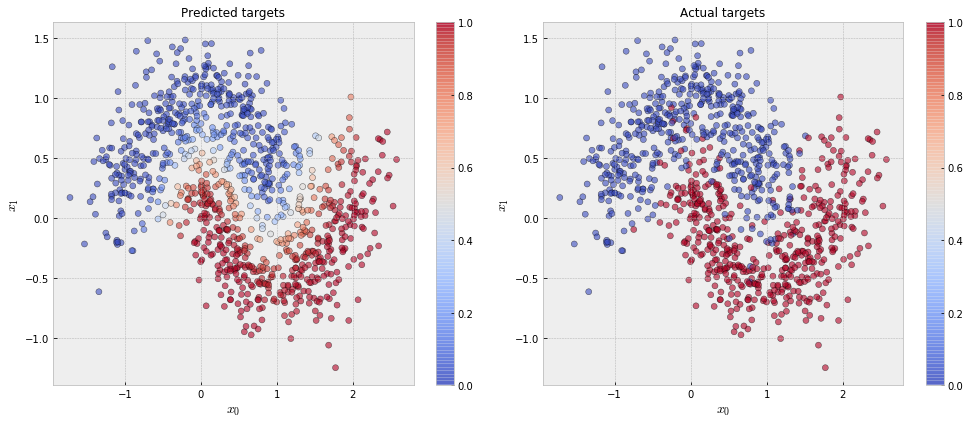

In [172]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred.detach().numpy().flatten(), alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Predicted targets", fontsize=12)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, edgecolor='k',
            cmap=plt.cm.coolwarm, vmin=0, vmax=1)
plt.colorbar()
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title("Actual targets", fontsize=12)
plt.tight_layout()

In [28]:
PROBLEM_ID = 3
GRADE = 0

if TEST:
    total_grade += GRADE

In [0]:
if TEST:
    print(f"{STUDENT}: {int(100 * total_grade / MAX_POINTS)}")